In [11]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [12]:
# 5.2.2 Extract Features
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc_features.T  # shape: (time, n_mfcc)

In [13]:
# 5.2.3 Training HMM
def train_hmm(features_list):
    lengths = [len(f) for f in features_list]      # sequence lengths
    X = np.vstack(features_list)                   # combined feature sequences
    model = hmm.GaussianHMM(
        n_components=4,
        covariance_type="full",
        n_iter=100,
        verbose=False
    )
    model.fit(X, lengths)
    return model

In [14]:
def predict_hmm(models, test_features):
    scores = {cls: model.score(test_features) for cls, model in models.items()}
    return max(scores, key=scores.get)

In [7]:
#Function to predict class of test features
def predict_hmm(models, test_features):
    scores = {cls: model.score(test_features) for cls, model in models.items()}  # Compute log-likelihood
    return max(scores, key=scores.get)  # Return class with highest likelihood

In [16]:
# ================== MAIN FLOW ==================

data_dir = r"E://Projects//digits"  # TODO: set your dataset root path
classes = ["D0", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9"]

# Load all data once
all_data = []    # list of feature sequences
all_labels = []  # list of labels

for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    for file_name in os.listdir(class_dir):
        if not file_name.lower().endswith(".wav"):
            continue
        file_path = os.path.join(class_dir, file_name)
        features = extract_features(file_path)
        all_data.append(features)
        all_labels.append(cls)

all_data = np.array(all_data, dtype=object)
all_labels = np.array(all_labels)

# 5.2.5 Evaluating Metrics with K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracies = []
all_true_labels_overall = []
all_predicted_labels_overall = []

for fold, (train_idx, test_idx) in enumerate(kf.split(all_data), 1):
    print(f"\n=== Fold {fold}/{k_folds} ===")

    train_data, test_data = all_data[train_idx], all_data[test_idx]
    train_labels, test_labels = all_labels[train_idx], all_labels[test_idx]

    # Train one HMM per class
    models = {}
    for cls in np.unique(train_labels):
        cls_features = [train_data[i] for i in range(len(train_data)) if train_labels[i] == cls]
        print(f"Training HMM for class: {cls}")
        models[cls] = train_hmm(cls_features)

    # Evaluate on test set
    correct = 0
    total = 0
    fold_true_labels = []
    fold_predicted_labels = []

    for i, test_features in enumerate(test_data):
        true_label = test_labels[i]
        predicted_label = predict_hmm(models, test_features)

        fold_true_labels.append(true_label)
        fold_predicted_labels.append(predicted_label)

        if predicted_label == true_label:
            correct += 1
        total += 1

        print(f"Test Sample {i+1}: True Label = {true_label}, Predicted = {predicted_label}")

    fold_accuracy = (correct / total) * 100
    accuracies.append(fold_accuracy)
    print(f"Fold {fold} Accuracy: {fold_accuracy:.2f}%")

    all_true_labels_overall.extend(fold_true_labels)
    all_predicted_labels_overall.extend(fold_predicted_labels)

# Final accuracy
final_accuracy = np.mean(accuracies)
print(f"\n=== Final K-Fold Cross-Validation Accuracy: {final_accuracy:.2f}% ===")



=== Fold 1/5 ===
Training HMM for class: D0
Training HMM for class: D1
Training HMM for class: D2
Training HMM for class: D3
Training HMM for class: D4
Training HMM for class: D5
Training HMM for class: D6
Training HMM for class: D7
Training HMM for class: D8
Training HMM for class: D9
Test Sample 1: True Label = D0, Predicted = D0
Test Sample 2: True Label = D0, Predicted = D0
Test Sample 3: True Label = D0, Predicted = D0
Test Sample 4: True Label = D0, Predicted = D0
Test Sample 5: True Label = D0, Predicted = D0
Test Sample 6: True Label = D0, Predicted = D0
Test Sample 7: True Label = D0, Predicted = D0
Test Sample 8: True Label = D0, Predicted = D0
Test Sample 9: True Label = D0, Predicted = D7
Test Sample 10: True Label = D1, Predicted = D1
Test Sample 11: True Label = D1, Predicted = D0
Test Sample 12: True Label = D1, Predicted = D0
Test Sample 13: True Label = D1, Predicted = D0
Test Sample 14: True Label = D1, Predicted = D1
Test Sample 15: True Label = D1, Predicted = D0
T

In [18]:
# Compute and print overall accuracy
final_accuracy = np.mean(accuracies)
print(f"\n=== Final K-Fold Cross-Validation Accuracy: {final_accuracy:.2f}% ===")


=== Final K-Fold Cross-Validation Accuracy: 59.30% ===


<Figure size 800x600 with 0 Axes>

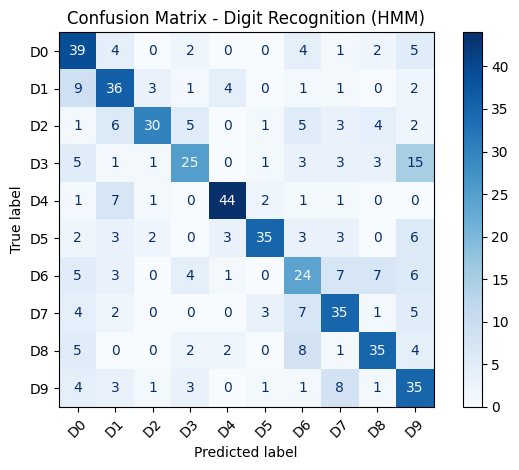

In [19]:
# 5.2.7 Plot the Confusion Matrix (overall)
cm = confusion_matrix(all_true_labels_overall, all_predicted_labels_overall, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Digit Recognition (HMM)")
plt.grid(False)
plt.tight_layout()
plt.show()